**Pose Estimate**

mediapipe를 이용한 landmark의 좌표를 저장하여 자세 추론의 데이터셋으로 활용한다

In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
import os

# Initialize MediaPipe Hands
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

image_folder_path = r'C:/Users/user/Downloads/standing' # 각 자세별 데이터셋에 따라 저장 폴더명은 변경한다

landmarks_to_extract = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_HEEL,
    mp_pose.PoseLandmark.RIGHT_HEEL,
    mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX
]

# 전체 데이터를 저장할 리스트 생성
landmark_labels = []

for image_file in os.listdir(image_folder_path):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일 확장자 확인
        image_path = os.path.join(image_folder_path, image_file)

        # 이미지 읽기
        image = cv2.imread(image_path)

        # BGR 이미지를 RGB로 변환
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # MediaPipe Pose로 이미지에서 랜드마크 추출
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            # 각 이미지의 랜드마크 좌표 추출
            for landmark_idx in landmarks_to_extract:
                # 랜드마크 좌표값 추출 (x, y, z 좌표)
                landmark = results.pose_landmarks.landmark[landmark_idx]
                landmark_labels.append({
                    'image': image_file,
                    'landmark': landmark_idx.name,
                    'x': landmark.x,
                    'y': landmark.y,
                    'z': landmark.z
                })


# Convert to DataFrame
landmarks_df = pd.DataFrame(landmark_labels)

# Optionally, save the DataFrame to a CSV
landmarks_df.to_csv('landmarks_standing.csv', index=False) #저장할 데이터셋 파일명 변경

데이터셋 마운트 후 해당 자료에서 x,y,z 값을 불러온다.

각 이미지 별 하체 10개의 landmarks를 불러오므로 입력값은  (30, ) 의 형태를 지닌다.

flatten 하여 landmark 당 x,y,z 3열의 자료를 1행 30열의 1D로 바꿔준다

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data using pandas to handle mixed data types
df_standing = pd.read_csv('/content/drive/MyDrive/standing.csv')
df_oneleg_success = pd.read_csv('/content/drive/MyDrive/landmarks_oneleg_good.csv')
df_oneleg_failed = pd.read_csv('/content/drive/MyDrive/landmarks_oneleg_bad.csv')

def process_data(df):
    grouped = df.groupby('image')
    data = []

    for _, group in grouped:
        # Flatten x, y, z coordinates into a single row vector (30,)
        flattened = group[['x', 'y', 'z']].values.flatten()
        data.append(flattened)

    return np.array(data)

# Process the data
data_standing = process_data(df_standing)
data_oneleg_success = process_data(df_oneleg_success)
data_oneleg_failed = process_data(df_oneleg_failed)

# Create labels
label_stand = [0] * len(data_standing)
label_oneleg_bad = [1] * len(data_oneleg_failed)
label_oneleg_good = [2] * len(data_oneleg_success)


# Concatenate the data and labels
data = np.concatenate((data_standing, data_oneleg_success, data_oneleg_failed), axis=0)
label = np.array(label_stand + label_oneleg_good + label_oneleg_bad)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(data.shape)
print(label.shape)

(878, 30)
(878,)
(1098, 30)
(1098,)


위에서 도출된 데이터셋의 형태 (n , 30)를 참고하여

(30, )의 최초 입력 형태를 맞춰서 모델에 넣어준다

과적합을 막기 위해 dropout 추가

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = keras.Sequential([
    keras.layers.Dense(128, input_shape=(30,), activation='relu'),
    keras.layers.Dropout(0.3),  # Adding dropout to prevent overfitting
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,634 (57.16 KB)

 Trainable params: 14,634 (57.16 KB)

 Non-trainable params: 0 (0.00 B)

**Sequential 모델을 사용한 이유에 대한 GPT의 답변**

Keras와 같은 딥 러닝 프레임워크에 사용되는 것과 같은 순차 모델은 다음과 같은 몇 가지 주요 이유로 자세 추론 모델에 사용되는 경우가 많습니다.

**계층 구조**: 순차 모델을 사용하면 신경망 구축에 대한 간단한 계층별 접근 방식이 가능합니다. 각 레이어의 출력은 다음 레이어의 입력이 됩니다. 이는 모델이 이미지나 센서 데이터와 같은 원시 데이터에서 더 높은 수준의 특징을 점진적으로 추출하고 자세와 관련된 복잡한 패턴을 학습할 수 있는 자세 추론에 유용합니다.

**단순성 및 효율성**: Sequential API는 사용하고 이해하기 쉬우므로 빠른 프로토타이핑 및 간단한 아키텍처에 적합합니다. 자세 추론 모델에는 실시간 처리가 필요한 경우가 많기 때문에 순차 모델의 단순성은 더 쉽게 최적화할 수 있는 효율적인 구현으로 이어질 수 있습니다.

**다양한 사용 사례에 적합**: 많은 자세 추론 작업에는 여러 입력, 출력 또는 비선형 레이어 연결을 포함하는 매우 복잡한 아키텍처가 필요하지 않습니다. 이러한 작업의 경우 일반적으로 순차 모델이 좋은 성능을 달성하는 데 충분합니다.

**사전 훈련된 모델과의 호환성**: 순차 모델은 특정 자세 추론 작업에 맞게 미세 조정할 수 있는 사전 훈련된 모델과 호환되는 경우가 많습니다. 이를 통해 기존 지식을 활용하여 모델의 정확도를 잠재적으로 향상시키는 동시에 시간과 계산 리소스를 절약할 수 있습니다.

**디버깅 용이성**: 순차 모델은 간단한 구조로 인해 교육 중에 디버그하고 모니터링하기가 더 쉽습니다. 이는 모델이 데이터로부터 올바르게 학습하도록 보장하는 것이 정확한 자세 감지를 위해 중요한 자세 추론에서 특히 중요합니다.

전반적으로 순차 모델은 많은 자세 추론 애플리케이션에 대한 단순성, 효율성 및 충분한 기능의 균형을 제공하므로 이 영역에서 인기 있는 선택이 됩니다.

---------------------------------------------------------------------------

모델의 구조를 확인하고 사용된 파라미터 값을 확인해준다

이후에 batch 사이즈와 epoch를 적절히 조절하여 최종 모델 정확도 상승까지 학습시킨다

In [ ]:
# Train the model with the specified batch size and epochs
model.fit(X_train, y_train, batch_size=32, epochs=200, verbose=1)

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1239 - loss: 2.3112
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2135 - loss: 2.2211
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2942 - loss: 2.1449
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4044 - loss: 2.0060
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4619 - loss: 1.8701
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4444 - loss: 1.7429
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4279 - loss: 1.6649
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4396 - loss: 1.5282
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4578 - loss: 1.4412
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4929 - loss: 1.3273
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4308 - loss: 1.3619
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

epoch 200번 실행후 최종 테스트 정확도 93.64% 확인

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9129 - loss: 0.1718  
Test Accuracy: 0.9364


.h5 모델로 저장할 경우 legacy 코드로 .keras 로 저장하길 권유하는 에러 메세지 출력됨

저장 여부 확인을 위해 print 명령어 추가해준다

In [ ]:
try:
    model.save('posture_detection_model.keras')
    print("Model saved as 'posture_detection_model.keras'")
except Exception as e:
    print(f"Failed to save the model: {e}")

Model saved as 'posture_detection_model.keras'


In [ ]:
pip install mediapipe # 아래 mediapipe 실행 전 모듈 설치

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [ ]:
아래 코드는 COLAB 환경에서 불가한 cv2.VideoCapture(0) 사용으로 로컬 환경에서 실행하기

In [ ]:
### COLAB 환경에서 불가한 cv2.VideoCapture(0) 사용으로 로컬 환경에서 실행하기

import cv2
import os
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load the trained dense model
model = tf.keras.models.load_model('posture_detection_model.keras')

# Initialize MediaPipe Pose detection
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Specify the landmarks to extract (using indices from MediaPipe's pose landmarks)
landmarks_to_extract = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_HEEL,
    mp_pose.PoseLandmark.RIGHT_HEEL,
    mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX
]

# Function to extract specific pose landmarks
def extract_selected_landmarks(results):
    if not results.pose_landmarks:
        return None
    landmarks = []

    # Extract only the selected landmarks
    for landmark_idx in landmarks_to_extract:
        landmark = results.pose_landmarks.landmark[landmark_idx]
        landmarks.append([landmark.x, landmark.y, landmark.z])

    return np.array(landmarks).flatten()

# Initialize the camera
cap = cv2.VideoCapture(0)

#캡쳐화면 저장할 경로 지정 및 생성
save_path = r'C:\Users\user\Downloads\est_example'
os.makedirs(save_path, exist_ok=True)  # 폴더가 없으면 생성

# 파일 번호를 기록할 변수
file_counter = 1

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB for MediaPipe processing
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    # If pose landmarks are detected
    if results.pose_landmarks:
        # Extract selected landmarks
        landmarks = extract_selected_landmarks(results)

        if landmarks is not None:
            # # Normalize the landmarks in the same way as during training
            # landmarks = (landmarks - np.mean(landmarks)) / np.std(landmarks)

            # Prepare the data for prediction
            input_data = np.expand_dims(landmarks, axis=0)  # Shape (1, num_features)

            # Make a prediction using the model
            prediction = model.predict(input_data)

            # Determine if the posture is correct (prediction close to 1) or incorrect (close to 0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            posture_map = {0: 'Standing', 1: 'Correct Posture', 2: 'Incorrect Posture'}
            posture_status = posture_map[predicted_class]

            # Set the color based on the posture status
            if predicted_class == 2:
                color = (0, 0, 255)  # Red for incorrect
            elif predicted_class == 1:
                color = (0, 255, 0)  # Green for correct
            else:
                color = (255, 255, 0)  # Yellow for standing

            # Display the result on the frame
            cv2.putText(frame, posture_status, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

    # Draw the landmarks on the frame
    mp.solutions.drawing_utils.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Display the frame
    cv2.imshow('Posture Detection', frame)

    # 키보드 입력 대기
    key = cv2.waitKey(10) & 0xFF

    if key == ord('s'):
        # 파일 이름 생성 (예: captured_image_1.jpg)
        file_name = f'example_{file_counter}.jpg'

        # 저장 경로와 파일명 결합
        full_save_path = os.path.join(save_path, file_name)

        # 이미지 저장
        cv2.imwrite(full_save_path, frame)
        print(f"사진 저장 완료: {full_save_path}")

        # 파일 번호 증가
        file_counter += 1

    # Exit if 'q' is pressed
    elif cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release the camera and close windows
cap.release()
cv2.destroyAllWindows()

아래와 같이 한 발 들기에 대한 3가지 추론값을 얻을 수 있다
(정확한 자세, 부정확한 자세, 차렷 자세)

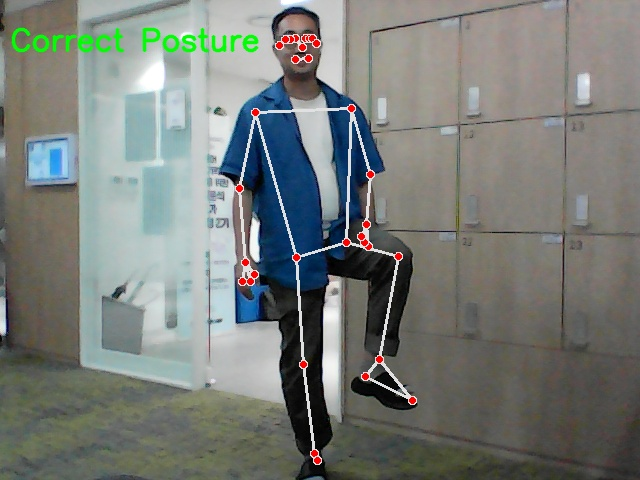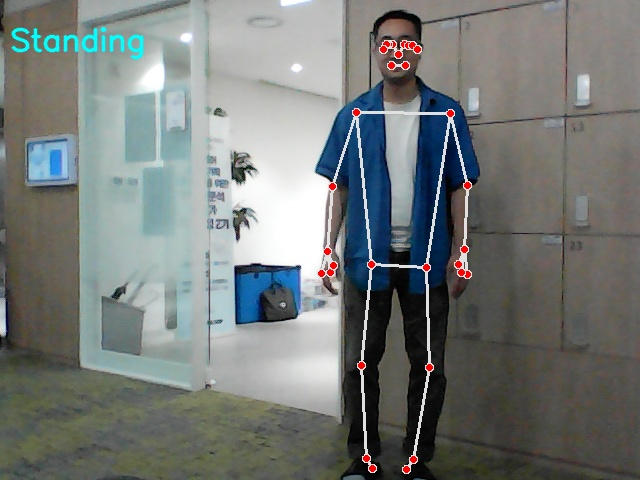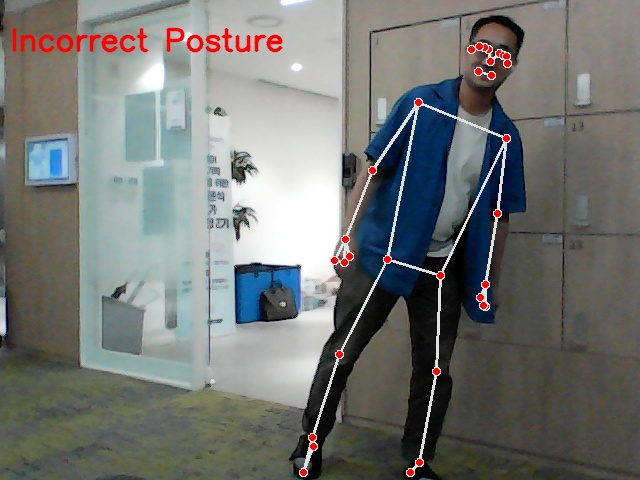